In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
!pip install --upgrade "transformers>=4.53.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 83.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.52.4
    Uninstalling transformers-4.52.4:
      Successfully uninstalled transformers-4.52.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth 2025.7.3 requires tyro, which is not installed.
unsloth-zoo 2025.7.4 requires msgspec, which is not installed.
unsloth-zoo 2025.7.4 requires tyro, which is not installed.


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
from torchvision import transforms
from PIL import Image
import os

In [4]:
# import re

# # Text preprocessing function
# def preprocess_text(text):
#     # Convert to lowercase
#     text = text.lower()
#     # Remove URLs
#     text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
#     # Remove special characters and numbers, keep only letters and basic punctuation
#     text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
#     # Remove extra whitespace
#     text = ' '.join(text.split())
#     return text

In [5]:
# Load text data
train_df = pd.read_csv("/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_train.csv")
val_df = pd.read_csv("/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_val.csv")
test_df = pd.read_csv("/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Text_dataset/A_test.csv")

In [6]:
# # Load text data
# train_df = train_df.iloc[0:100]
# val_df = val_df.iloc[0:40]
# test_df = test_df.iloc[0:20]

In [7]:
train_df

,index,text,label
0,1001.png,transgirls who grow boobs but keep their cock ...,0
1,1005.png,realistic and wholesome representation of tran...,0
2,1008.png,united lgbt united sponsored you can color you...,0
3,1009.png,neolib politician i'm going to fuck my cat and...,1
4,1010.png,dad i'm gay i love you no matter what i also s...,1
...,...,...,...
4045,9992.png,31 r furry u divaqueen98 15h i redd it artist ...,1
4046,9993.png,oneself nominal xenogenders when one's gender ...,0
4047,9996.png,sport menu pf mann max sherry bearded powerlif...,1
4048,9997.png,a tale of one woman's shocking desire to liter...,0


In [8]:
# # Apply text preprocessing
# train_df['text'] = train_df['text'].apply(preprocess_text)
# val_df['text'] = val_df['text'].apply(preprocess_text)
# test_df['text'] = test_df['text'].apply(preprocess_text)

In [9]:
# Create image paths based on index and label structure for A_train_img
image_base_path = "/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset"
train_df['image_path'] = train_df.apply(lambda row: os.path.join(image_base_path, f"A_train_img/{'Hate' if row['label'] == 1 else 'No Hate'}/{row['index']}"), axis=1)
val_df['image_path'] = val_df['index'].apply(lambda x: os.path.join(image_base_path, f"A_val_img/{x}"))
test_df['image_path'] = test_df['index'].apply(lambda x: os.path.join(image_base_path, f"A_test_img/{x}"))

In [10]:
# Filter out rows with missing text
train_df = train_df[train_df['text'].notna() & (train_df['text'] != '')]
val_df = val_df[val_df['text'].notna() & (val_df['text'] != '')]
test_df = test_df[test_df['text'].notna() & (test_df['text'] != '')]

In [11]:
# Filter out rows with missing text or images
def filter_missing_images(df):
    df = df[df['text'].notna() & (df['text'] != '')].copy()
    df['image_exists'] = df['image_path'].apply(os.path.exists)
    print(f"Total rows: {len(df)}, Rows with missing images: {len(df[~df['image_exists']])}")
    print("Sample missing paths:", df[~df['image_exists']]['image_path'].head().tolist())
    return df[df['image_exists']].drop(columns=['image_exists'])

train_df = filter_missing_images(train_df)
val_df = filter_missing_images(val_df)
test_df = filter_missing_images(test_df)

Total rows: 4050, Rows with missing images: 388
Sample missing paths: ['/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/Hate/1914.png', '/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/Hate/2962.png', '/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/Hate/2983.png', '/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/Hate/2993.png', '/kaggle/input/meme-dataset/meme_dataset/meme_dataset/Image_dataset/A_train_img/Hate/2997.png']
Total rows: 506, Rows with missing images: 0
Sample missing paths: []
Total rows: 507, Rows with missing images: 0
Sample missing paths: []


In [12]:
# Select relevant columns
train_df = train_df[["text", "image_path", "label"]]
val_df = val_df[["text", "image_path", "label"]]
test_df = test_df[["index","text", "image_path"]]  # No label for test

In [13]:
print("==============================================")
print(f'The shape of the train dataset is: {train_df.shape}')
print(f'The shape of the val dataset is: {val_df.shape}')
print(f'The shape of the test dataset is: {test_df.shape}')
print("==============================================")
print(f'The number of sentiments in train category is:\n{train_df.label.value_counts()}')
print("==============================================")

The shape of the train dataset is: (3662, 3)
The shape of the val dataset is: (506, 3)
The shape of the test dataset is: (507, 3)
The number of sentiments in train category is:
label
0    1930
1    1732
Name: count, dtype: int64


Preprocessed text: hp tsc welcome to bill gatesmartm please stay still while i check your temperature deep state security gay thought inducing rays m oo proud american father thanks for your compliance m
Sentiment: 1


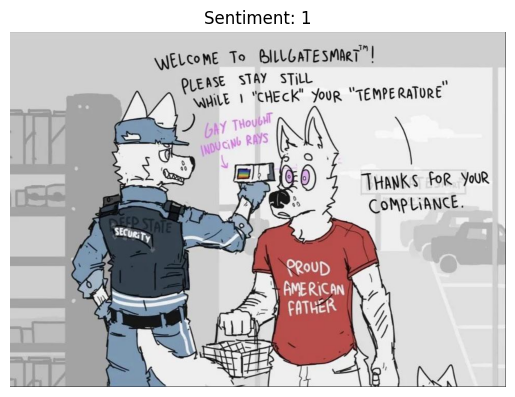

In [14]:
import matplotlib.pyplot as plt
# your current code
index = 12
sample_text = train_df["text"].iloc[index]
image_path = train_df["image_path"].iloc[index]
sentiment = train_df["label"].iloc[index]

print("Preprocessed text:", sample_text)
print("Sentiment:", sentiment)

if os.path.exists(image_path):
    sample_image = Image.open(image_path)
    
    # show with matplotlib
    plt.imshow(sample_image)
    plt.axis("off")  # optional, hides axis
    plt.title(f"Sentiment: {sentiment}")
    plt.show()
else:
    print(f"Image not found at: {image_path}")

In [15]:
from datasets import Dataset
from PIL import Image
import os

instruction = "Analyze this meme image and its text content to determine if it contains hate speech. Respond with '0' if the content is not hateful, or '1' if it contains hate speech."

def convert_to_conversation(sample, index):
    if index % 400 == 0:
        print(f"Processing sample: {index}")

    image_path = sample["image_path"]

    image = Image.open(image_path).convert("RGB").resize((224, 224))

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": image}  # ✅ PIL image, not dict
            ]
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": str(sample["label"])}  # Should be "0" or "1"
            ]
        }
    ]
    return {"messages": conversation}



In [16]:
# Convert all records
train_dataset = []
for idx, sample in enumerate(train_df.to_dict("records")):
    result = convert_to_conversation(sample, idx)
    if result:
        train_dataset.append(result)

train_dataset[1]

Processing sample: 0
Processing sample: 400
Processing sample: 800
Processing sample: 1200
Processing sample: 1600
Processing sample: 2000
Processing sample: 2400
Processing sample: 2800
Processing sample: 3200
Processing sample: 3600


{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "Analyze this meme image and its text content to determine if it contains hate speech. Respond with '0' if the content is not hateful, or '1' if it contains hate speech."},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=224x224>}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': '0'}]}]}

In [17]:
# Convert all records
val_dataset = []
for idx, sample in enumerate(val_df.to_dict("records")):
    result = convert_to_conversation(sample, idx)
    if result:
        val_dataset.append(result)

val_dataset[1]

Processing sample: 0
Processing sample: 400


{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': "Analyze this meme image and its text content to determine if it contains hate speech. Respond with '0' if the content is not hateful, or '1' if it contains hate speech."},
    {'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=224x224>}]},
  {'role': 'assistant', 'content': [{'type': 'text', 'text': '0'}]}]}

In [18]:
# !pip install unsloth

In [19]:
import unsloth
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-12 08:10:05.927421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752307806.291833      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752307806.397811      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.3: Fast Qwen2 patching. Transformers: 4.53.2.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.97G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. You can rename the file or load and save the processor back which renames it automatically. Loading from `preprocessor.json` will be removed in v5.0.


chat_template.json: 0.00B [00:00, ?B/s]

In [20]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 128,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 128,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 313,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

In [21]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from unsloth import FastVisionModel

FastVisionModel.for_training(model)  # Enable training mode for vision models

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=train_dataset,   # your list or dataset
    eval_dataset=val_dataset,      # ✅ Add validation dataset
    args=SFTConfig(
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        warmup_steps=5,
        num_train_epochs=5,
        # max_steps = 50,
        learning_rate=1e-4,
        logging_steps=1,
        eval_steps=10,                       # ✅ Evaluate every 50 steps
        eval_strategy="steps",               # ✅ Trigger eval by steps
        save_strategy="no",
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="cosine",
        seed=3407,
        output_dir="outputs",
        report_to="none",

        # Vision-specific flags
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        dataset_num_proc=4,
        max_seq_length=2048,
    ),
)

trainer_stats = trainer.train()

Unsloth: Model does not have a default image size - using 512


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,662 | Num Epochs = 5 | Total steps = 290
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 1 x 1) = 64
 "-____-"     Trainable parameters = 412,172,288 of 8,704,338,944 (4.74% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
10,0.181500,0.052430
20,0.337600,0.380459
30,0.010700,0.010414
40,0.010300,0.009509
50,0.013000,0.009033
60,0.009400,0.008796
70,0.009300,0.008336
80,0.008000,0.007973
90,0.007100,0.007669
100,0.007200,0.007701


Unsloth: Will smartly offload gradients to save VRAM!


In [22]:
test_df.head()

,index,text,image_path
0,1002.png,imagine only being able to date this meme was ...,/kaggle/input/meme-dataset/meme_dataset/meme_d...
1,1011.png,every company during pride month i said we gay...,/kaggle/input/meme-dataset/meme_dataset/meme_d...
2,1040.png,ns righ ai fect just d trans phobe ersion py i...,/kaggle/input/meme-dataset/meme_dataset/meme_d...
3,1055.png,gay marriage shouldn't exist it should just be...,/kaggle/input/meme-dataset/meme_dataset/meme_d...
4,1115.png,me my gender staying female for a few days my ...,/kaggle/input/meme-dataset/meme_dataset/meme_d...


In [23]:
from unsloth import FastVisionModel
from transformers import TextStreamer
from PIL import Image
import pandas as pd
import json

# ✅ Set inference mode
FastVisionModel.for_inference(model)

# ✅ Your hate speech detection instruction
instruction = "Analyze this meme image and its text content to determine if it contains hate speech. Respond with '0' if the content is not hateful, or '1' if it contains hate speech."

# ✅ Streamer for nice output (optional)
streamer = TextStreamer(tokenizer, skip_prompt=True)

# ✅ Store results here
results = []

model.eval()

# ✅ Iterate over test_df
for i, row in test_df.iterrows():
    
    image_path = row["image_path"]
    index_value = row["index"]  # should be like '1002.png'
    
    # Load and resize image
    image = Image.open(image_path).convert("RGB").resize((224, 224))
    
    # Create chat-style message
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": image}
            ]
        }
    ]
    
    # Tokenize with chat template
    input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
    
    # Prepare inputs
    inputs = tokenizer(
        image,
        input_text,
        add_special_tokens=False,
        return_tensors="pt"
    ).to("cuda")
    
    # Generate prediction
    outputs = model.generate(
        **inputs,
        max_new_tokens=1,
        temperature=0.1,
        return_dict_in_generate=True,
        output_scores=False
    )
    
    # Decode prediction
    predicted_token_ids = outputs.sequences[0]
    prediction = tokenizer.decode(predicted_token_ids, skip_special_tokens=True).strip()

    # print(prediction)
    
    answer = prediction[-1]
    
    # print(prediction)
    print("Answer : ", answer)
    
    results.append({
        "index": index_value,
        "prediction": int(answer)
    })
    
    if (i + 1) % 100 == 0:
        print(f"Predicted {i + 1} samples")

    # except Exception as e:
    #     print(f"Error at row {i} ({row['index']}): {e}")


print("Done")

Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  0
Answer :  0
Answer :  0
Answer :  0
Answer :  1
Answer :  0
Answer :  0
Answer :  0
Answer :  1
Answer :  1
Answer :  0
Answer :  1
Answer :  0
Answer :  0
Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  0
Answer :  0
Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  0
Answer :  0
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  0
Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  1
Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  1
Answer :  0
Answer :  0
Answer :  0
Answer :  0
Answer :  1
Answer :  0
Answer :  1
Answer :  1
Answer :  0
Answer :  0
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  0
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  0
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  1
Answer :  0
Answer :  1
Answ

In [24]:
import json
import zipfile

# ✅ Save to JSONL
with open("submission.json", "w", encoding="utf-8") as f:
    for item in results:
        f.write(json.dumps(item) + "\n")

print("✅ Saved all predictions to submission.json")

# ✅ Create zip file and add the JSONL file
with zipfile.ZipFile("ref_Sakib.zip", "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write("submission.json")

print("✅ Zipped submission.json into ref_Sakib.zip")


✅ Saved all predictions to submission.json
✅ Zipped submission.json into ref_Sakib.zip
